In [ ]:
# !cd /content/drive/MyDrive/Project_3/data_final
# !unrar x /content/drive/MyDrive/Project_3/data_final/data_final.rar

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Đường dẫn đến dữ liệu âm thanh
DATA_PATH = "/content/drive/MyDrive/Project_3/data_final/data_final"  # Thay thế bằng đường dẫn của bạn

# Các thông số âm thanh
SAMPLE_RATE = 16000  # Tần số mẫu
# duration_seconds=3
num_coefficients = 40  # Số MFCCs
frame_length_ms = 300
hop_length_ms=5

# num_coefficients_values = [13, 20, 30, 40, 50, 60]
# frame_length_values = [25, 50, 100, 200, 300, 400, 500, 800]  # in milliseconds
# hop_length_values = [5, 25, 50, 100, 200, 300, 400, 500]  # in milliseconds


In [ ]:
def extract_mfcc(file_path,num_coefficients=num_coefficients, frame_length_ms=frame_length_ms, hop_length_ms=hop_length_ms, sampling_rate=SAMPLE_RATE):
    """Trích xuất đặc trưng MFCC từ file âm thanh."""
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    frame_length = int(sr * frame_length_ms / 1000)
    hop_length = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=num_coefficients, n_fft=frame_length, hop_length=hop_length
    )
    return mfccs.T  # Chuyển thành shape (time_steps, n_features)


In [ ]:
def load_data(data_path):
    X, y = [], []
    labels = os.listdir(data_path)  # Thư mục con là nhãn
    label_map = {label: idx for idx, label in enumerate(labels)}

    print("Mapping between labels and indices (label_map):")
    print(label_map)
    print("\n")

    for label in labels:
        label_dir = os.path.join(data_path, label)
        print(f"Processing label: {label} (Folder: {label_dir})")

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            print(f"  File: {file_path}")

            # Trích xuất MFCC
            mfcc = extract_mfcc(file_path)
            print(f"\tMFCC shape: {mfcc.shape}")

            X.append(mfcc)
            y.append(label_map[label])

    print("\nFinal dataset shapes:")
    print(f"  X: {len(X)} samples")
    print(f"  y: {len(y)} labels")

    return np.array(X), np.array(y), label_map



In [ ]:
X, y, label_map = load_data(DATA_PATH)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encoding cho nhãn
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# X, y, label_map = load_data(DATA_PATH)

# # Chia dữ liệu theo tỷ lệ thời gian, không sử dụng random_state và stratify
# train_size = int(0.8 * len(X))  # 80% cho tập huấn luyện
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # One-hot encoding cho nhãn
# y_train = to_categorical(y_train, num_classes=len(label_map))
# y_test = to_categorical(y_test, num_classes=len(label_map))


Mapping between labels and indices (label_map):
{'GiaKhanh_Voice': 0, 'BaoNguyen_Voice': 1, 'HaiDuong_Voice': 2, 'HaoPhu_Voice': 3, 'HongYen_Voice': 4, 'MsUyen_Voice': 5, 'NhatTruong_Voice': 6, 'PhuocSang_Voice': 7, 'PhuocSinl_Voice': 8, 'VanThach_Voice': 9}


Processing label: GiaKhanh_Voice (Folder: /content/drive/MyDrive/Project_3/data_final/data_final/GiaKhanh_Voice)
  File: /content/drive/MyDrive/Project_3/data_final/data_final/GiaKhanh_Voice/GiaKhanh8_slice_1.wav
	MFCC shape: (601, 40)
  File: /content/drive/MyDrive/Project_3/data_final/data_final/GiaKhanh_Voice/GiaKhanh2_slice_10.wav
	MFCC shape: (601, 40)
  File: /content/drive/MyDrive/Project_3/data_final/data_final/GiaKhanh_Voice/GiaKhanh2_slice_12.wav
	MFCC shape: (601, 40)
  File: /content/drive/MyDrive/Project_3/data_final/data_final/GiaKhanh_Voice/GiaKhanh2_slice_9.wav
	MFCC shape: (601, 40)
  File: /content/drive/MyDrive/Project_3/data_final/data_final/GiaKhanh_Voice/GiaKhanh8_slice_5.wav
	MFCC shape: (601, 40)
  File: /

# `LSTM MODEL`

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

def build_lstm_model(input_shape, num_classes):
    # model = Sequential([
    #     Input(shape=input_shape),
    #     LSTM(128, return_sequences=True),
    #     BatchNormalization(),
    #     Dropout(0.3),
    #     LSTM(64, return_sequences=False),
    #     BatchNormalization(),
    #     Dropout(0.3),
    #     Dense(128, activation='relu'),
    #     Dense(num_classes, activation='softmax'),
    # ])
    model = Sequential([
        # LSTM Layer 1
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),

        # LSTM Layer 2
        LSTM(64, return_sequences=False),  # No sequences returned
        BatchNormalization(),
        Dropout(0.3),

        # Fully Connected Layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')  # Softmax for classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_map)
lstm_model = build_lstm_model(input_shape, num_classes)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 601, 128)            │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 601, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 601, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,514 (552.79 KB)

 Trainable params: 141,130 (551.29 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define checkpoint callback
checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Project_3/speaker_recognition_model/checkpoints/speaker_recognition_LSTM_model_prime_300_4_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

lstm_model.save("/content/drive/MyDrive/Project_3/speaker_recognition_model/speaker_recognition_LSTM_model_prime_300_4.keras")


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1418 - loss: 2.7881
Epoch 1: val_accuracy improved from -inf to 0.52038, saving model to /content/drive/MyDrive/Project_3/speaker_recognition_model/checkpoints/speaker_recognition_LSTM_model_prime_300_4_epoch_01_val_acc_0.52.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.1450 - loss: 2.7716 - val_accuracy: 0.5204 - val_loss: 1.9775
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4929 - loss: 1.4934
Epoch 2: val_accuracy improved from 0.52038 to 0.63636, saving model to /content/drive/MyDrive/Project_3/speaker_recognition_model/checkpoints/speaker_recognition_LSTM_model_prime_300_4_epoch_02_val_acc_0.64.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4953 - loss: 1.4870 - val_accuracy: 0.6364 - val_loss: 1.5994
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6889 - loss: 0.9683
Epoch 3: val_accuracy improved from 0.63636 to 0.78997, saving model to /content/drive/MyDriv

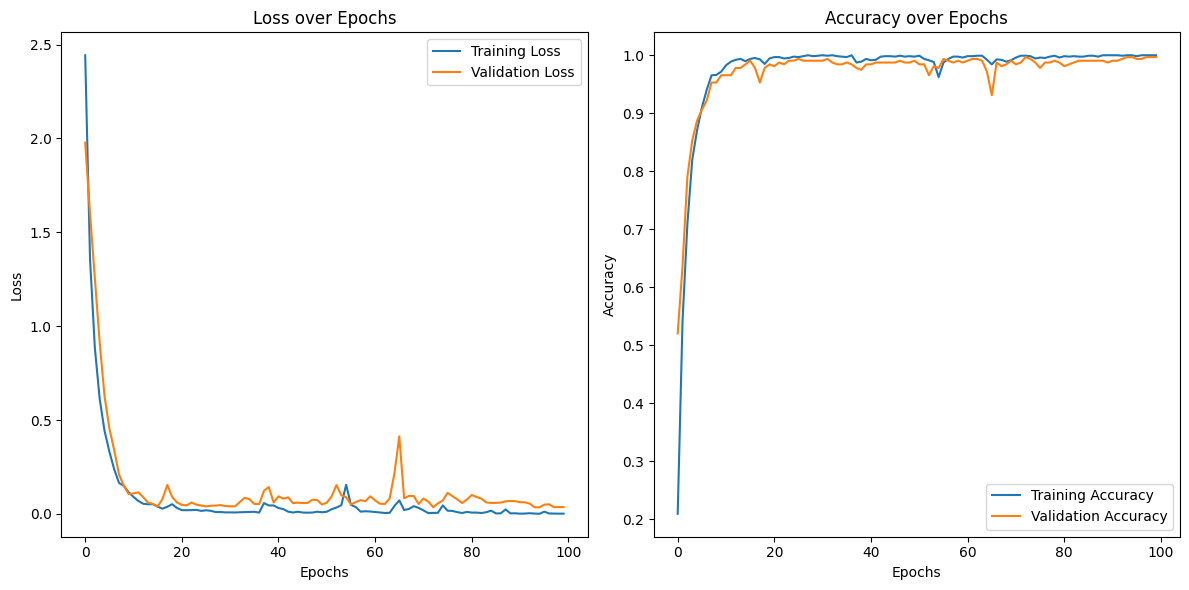

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step
---LSTM Model Results---
Loss: 0.036727167665958405
Accuracy: 0.9968652129173279
Precision: 0.9961538461538462
Recall: 0.9947368421052631
F1 Score: 0.9953365129835718


In [ ]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss và accuracy trong quá trình huấn luyện
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

# Sau khi huấn luyện và lưu mô hình, bạn có thể đánh giá mô hình bằng các chỉ số khác
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
y_pred = lstm_model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

# Tính các chỉ số khác
from sklearn.metrics import precision_score, recall_score, f1_score

lstm_precision = precision_score(y_test, y_pred_bin, average='macro')  # Hoặc 'weighted', 'micro', 'samples'
lstm_recall = recall_score(y_test, y_pred_bin, average='macro')
lstm_f1 = f1_score(y_test, y_pred_bin, average='macro')
# In kết quả
print("---LSTM Model Results---")
print(f"Loss: {lstm_loss}")
print(f"Accuracy: {lstm_accuracy}")
print(f"Precision: {lstm_precision}")
print(f"Recall: {lstm_recall}")
print(f"F1 Score: {lstm_f1}")
